## This notebook calibrates the Cpx-Liq machine learning barometr used by Thermobar. 
- We follow Petrelli, where a different random state is used for pressure and temperature
- Note, this will likely need rerunning a lot, because it seems if sklearn changes version too much, the pickles wont load. 
- With each change in Sklearn, the answer will likely change. The change from v023.2 resulted in a change of up to ~0.8 kbar per Cpx. This is sadly unavoidable as far as we know, although if you have a suggestion please let us know!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingRegressor

%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats
import warnings as w
import sys
sys.path.append("../../..")
import Thermobar as pt
pd.set_option('display.max_columns', None)

In [7]:
out_train=pt.import_excel('Train_data.xlsx',
                          sheet_name='Sheet1')
out_train_input=out_train['my_input']
Cpx_train=out_train['Cpxs']
Liq_train=out_train['Liqs']
Cpx_train_noID_noT=Cpx_train.drop(['Sample_ID_Cpx'], axis=1)
Liq_train_noID_noT=Liq_train#pt.normalize_liquid_jorgenson(liq_comps=Liq_train)
Liq_train_noID_noT['Citation.x']=out_train_input['Citation.x']
Liq_train_noID_noT['P_kbar']=out_train_input['P_kbar']
Liq_train_noID_noT['T_K']=out_train_input['T_C']+273.15
Liq_train_filtered = Liq_train_noID_noT.groupby('Citation.x').filter(lambda x: len(x) > 1)

Liq_train_filtered2=Liq_train_filtered.drop(['Sample_ID_Liq',  'Fe3Fet_Liq', 'NiO_Liq', 'Citation.x', 'P_kbar','T_K',
                                   'CoO_Liq', 'CO2_Liq', 'H2O_Liq', 'Cr2O3_Liq', 'P2O5_Liq', 'MnO_Liq'], axis=1)



x_train=Liq_train_filtered2.values


y_train_P=Liq_train_filtered['P_kbar']
y_train_T=Liq_train_filtered['T_K']

Liq_train_filtered['group'] = Liq_train_filtered['Citation.x'].astype('category').cat.codes


Random split RMSE for P: 1.82
Grouped split RMSE for P: 1.60


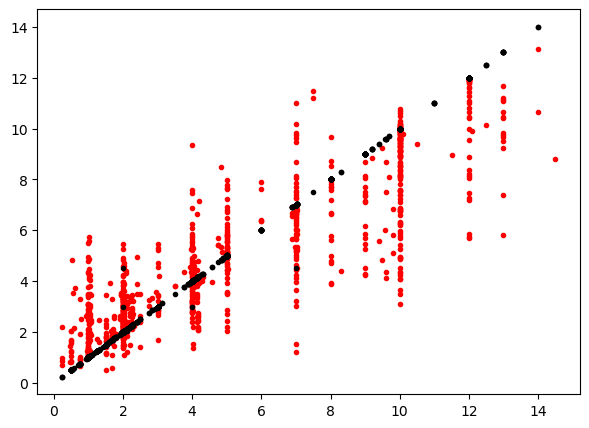

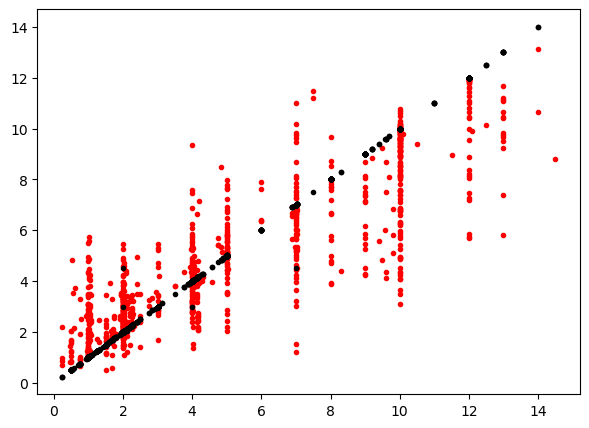

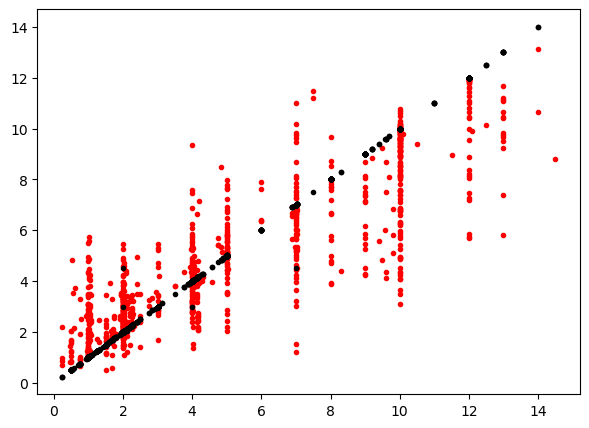

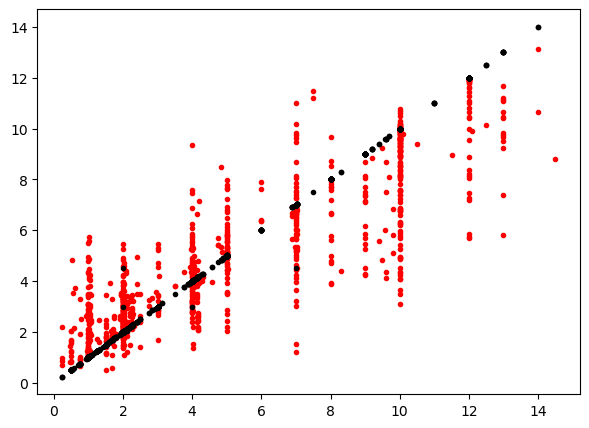

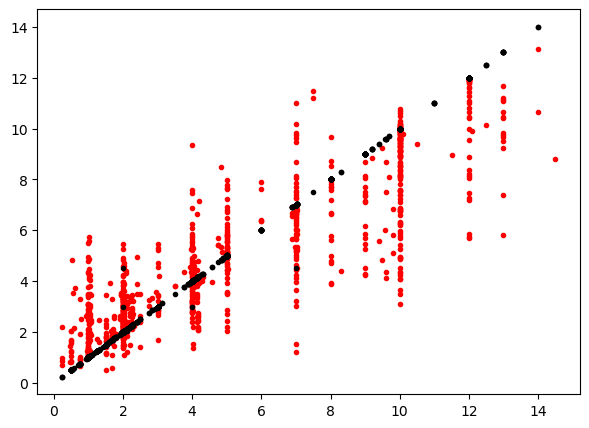

In [34]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold

# drop the specified columns from the dataframe
Liq_train_filtered2 = Liq_train_filtered.drop(['Sample_ID_Liq', 'Fe3Fet_Liq', 'NiO_Liq', 'Citation.x', 'P_kbar',
                                               'T_K', 'CoO_Liq', 'CO2_Liq', 'H2O_Liq', 'Cr2O3_Liq',
                                               'P2O5_Liq', 'MnO_Liq'], axis=1)

# define the features and target variables
x_train = Liq_train_filtered2.values
y_train_P = Liq_train_filtered['P_kbar']
y_train_T = Liq_train_filtered['T_K']

# perform random split
x_train_rand, x_val_rand, y_train_P_rand, y_val_P_rand = train_test_split(
    x_train, y_train_P, test_size=0.4, random_state=42)

# define the number of folds for cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# train and predict with random split and cross-validation with grouped split
model_rand = ExtraTreesRegressor(n_estimators=500, random_state=42)
model_grp = ExtraTreesRegressor(n_estimators=500, random_state=42)
rmse_P_rand = 0.0
rmse_P_grp = 0.0

for train_idx, val_idx in kf.split(x_train):
    x_train_grp, x_val_grp = x_train[train_idx], x_train[val_idx]
    y_train_P_grp, y_val_P_grp = y_train_P.iloc[train_idx], y_train_P.iloc[val_idx]
    
    # train and predict with random split
    model_rand.fit(x_train_rand, y_train_P_rand)
    y_pred_P_rand = model_rand.predict(x_val_rand)
    y_pred_P_train = model_rand.predict(x_train_rand)
    rmse_P_rand_fold = mean_squared_error(y_val_P_rand, y_pred_P_rand, squared=False)
    rmse_P_rand += rmse_P_rand_fold
    
    # train and predict with grouped split
    model_grp.fit(x_train_grp, y_train_P_grp)
    y_pred_P_grp = model_grp.predict(x_val_grp)
    rmse_P_grp_fold = mean_squared_error(y_val_P_grp, y_pred_P_grp, squared=False)
    rmse_P_grp += rmse_P_grp_fold
    fig, (ax1) = plt.subplots(1, 1, figsize=(7,5))
    ax1.plot(y_val_P_rand, y_pred_P_rand, '.r')
    ax1.plot(y_train_P_rand, y_pred_P_train, '.k')

rmse_P_rand /= n_splits
rmse_P_grp /= n_splits

# print the RMSE values
print(f"Random split RMSE for P: {rmse_P_rand:.2f}")
print(f"Grouped split RMSE for P: {rmse_P_grp:.2f}")


In [30]:
x_train_grp

array([[ 71.70958114,   0.26522267,  15.86915658, ...,   3.50314963,
          2.80693998,  43.        ],
       [ 74.97611325,   0.26542095,  13.47276704, ...,   3.22751873,
          3.9919311 ,  43.        ],
       [ 73.23744136,   0.22883295,  15.05938746, ...,   3.55235919,
          3.04020922,  43.        ],
       ...,
       [ 66.63182103,   0.54359189,  16.73635793, ...,   4.85051223,
          3.96194857, 100.        ],
       [ 66.15400711,   0.53358443,  16.85499058, ...,   4.89642185,
          3.8606403 , 100.        ],
       [ 67.10403967,   0.53724558,  16.4789751 , ...,   4.69056721,
          4.07066846, 100.        ]])

In [22]:
# create dataframe of random split indexes
rand_split_df = pd.DataFrame({
    'split': ['train']*len(x_train_rand) + ['val']*len(x_val_rand),
    'index': list(x_train_rand.index) + list(x_val_rand.index)
})

# perform grouped split based on 'Citation.x'
group_col = Liq_train_filtered['Citation.x'].astype('category').cat.codes
x_train_grp, x_val_grp, y_train_P_grp, y_val_P_grp, y_train_T_grp, y_val_T_grp = train_test_split(
    x_train, y_train_P, y_train_T, test_size=0.2, random_state=42, stratify=group_col)

# create dataframe of grouped split indexes
grp_split_df = pd.DataFrame({
    'split': ['train']*len(x_train_grp) + ['val']*len(x_val_grp),
    'index': list(x_train_grp.index) + list(x_val_grp.index)
})

# concatenate the two dataframes
result_df = pd.concat([rand_split_df, grp_split_df], keys=['random', 'grouped'])

# print the resulting dataframe
print(result_df)





              split  index
random  0     train      0
        1     train      1
        2     train      2
        3     train      3
        4     train      4
...             ...    ...
grouped 2234    val    443
        2235    val    444
        2236    val    445
        2237    val    446
        2238    val    447

[4478 rows x 2 columns]


In [23]:
result_df

split  index
random  0     train      0
        1     train      1
        2     train      2
        3     train      3
        4     train      4
...             ...    ...
grouped 2234    val    443
        2235    val    444
        2236    val    445
        2237    val    446
        2238    val    447

[4478 rows x 2 columns]

In [9]:
len(Liq_train_filtered)

2239

In [10]:
from sklearn.model_selection import train_test_split

# random train/test split
x_train_rand, x_val_rand, y_train_T_rand, y_val_T_rand, y_train_P_rand, y_val_P_rand = train_test_split(
    x_train, y_train_T, y_train_P, test_size=0.2, random_state=42)



In [20]:
# grouped train/test split
x_train_grp, x_val_grp, y_train_T_grp, y_val_T_grp, y_train_P_grp, y_val_P_grp = train_test_split(
    x_train, y_train_T, y_train_P, test_size=0.2, random_state=42, stratify=Liq_train_filtered['group'])

# create a dictionary that maps the category codes to citation values
citation_dict = dict(enumerate(Liq_train_filtered['Citation.x'].unique()))

# convert the category codes in y_train_T_grp and y_val_T_grp to citation values
citations_train = [citation_dict[code] for code in y_train_P_grp]
citations_val = [citation_dict[code] for code in y_val_P_grp]

print("Citation values in grouped training set:")
print(set(citations_train))

print("Citation values in grouped validation set:")
print(set(citations_val))

KeyError: 1.96

In [12]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error

# train and predict with random split
model_rand = ExtraTreesRegressor(n_estimators=100, random_state=42)
model_rand.fit(x_train_rand, y_train_T_rand)
y_pred_T_rand = model_rand.predict(x_val_rand)
rmse_T_rand = mean_squared_error(y_val_T_rand, y_pred_T_rand, squared=False)

# train and predict with grouped split
model_grp = ExtraTreesRegressor(n_estimators=100, random_state=42)
model_grp.fit(x_train_grp, y_train_T_grp)
y_pred_T_grp = model_grp.predict(x_val_grp)
rmse_T_grp = mean_squared_error(y_val_T_grp, y_pred_T_grp, squared=False)

In [13]:
print(f"Random split RMSE: {rmse_T_rand:.2f}")
print(f"Grouped split RMSE: {rmse_T_grp:.2f}")

Random split RMSE: 44.16
Grouped split RMSE: 33.72


In [16]:
# train and predict with random split for P
model_rand = ExtraTreesRegressor(n_estimators=500, random_state=42)
model_rand.fit(x_train_rand, y_train_P_rand)
y_pred_P_rand = model_rand.predict(x_val_rand)
rmse_P_rand = mean_squared_error(y_val_P_rand, y_pred_P_rand, squared=False)

# train and predict with grouped split for P
model_grp = ExtraTreesRegressor(n_estimators=500, random_state=42)
model_grp.fit(x_train_grp, y_train_P_grp)
y_pred_P_grp = model_grp.predict(x_val_grp)
rmse_P_grp = mean_squared_error(y_val_P_grp, y_pred_P_grp, squared=False)

print(f"Random split RMSE for P: {rmse_P_rand:.2f}")
print(f"Grouped split RMSE for P: {rmse_P_grp:.2f}")

Random split RMSE for P: 1.99
Grouped split RMSE for P: 1.88


In [17]:
print(f"Random split RMSE: {rmse_P_rand:.2f}")
print(f"Grouped split RMSE: {rmse_P_grp:.2f}")

Random split RMSE: 1.99
Grouped split RMSE: 1.88


In [10]:
x_train

array([[71.70958114,  0.26522267, 15.86915658, ...,  0.        ,
         0.        ,  0.        ],
       [75.54371033,  0.23454158, 13.18763308, ...,  0.        ,
         0.        ,  0.        ],
       [74.97611325,  0.26542095, 13.47276704, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [66.63182103,  0.54359189, 16.73635793, ...,  0.        ,
         0.        ,  0.        ],
       [66.15400711,  0.53358443, 16.85499058, ...,  0.        ,
         0.        ,  0.        ],
       [67.10403967,  0.53724558, 16.4789751 , ...,  0.        ,
         0.        ,  0.        ]])

In [11]:
# Scaling
scaler = StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)

# Corin says max features=#*2.3
maxF=int(np.round(21*(2/3), 0))

# Define the regressor, in our case the Extra Tree Regressor
crit="absolute_error"
regr_T = ExtraTreesRegressor(n_estimators=500, criterion=crit,
                             max_features=maxF, random_state=280) # random_state fixed for reproducibility

# Define the regressor, in our case the Extra Tree Regressor
regr_P = ExtraTreesRegressor(n_estimators=500, criterion=crit, 
                             max_features=maxF, random_state=80) # random_state fixed for reproducibility

# Train the model
regr_T.fit(x_train_scaled, y_train_T.ravel())
regr_P.fit(x_train_scaled, y_train_P.ravel())

ExtraTreesRegressor(criterion='absolute_error', max_features=14,
                    n_estimators=500, random_state=80)

In [12]:
from pickle import dump
dump(scaler, open('scaler_Greg21_Cpx_Liq_April24.pkl', 'wb'))


import joblib
joblib.dump(regr_P,  'ETR_Press_Greg21_Cpx_Liq_April24.pkl',compress=3)

joblib.dump(regr_T,  'ETR_Temp_Greg21_Cpx_Liq_April24.pkl',compress=3)

['ETR_Temp_Greg21_Cpx_Liq_April24.pkl']

In [11]:
x_test_scaled=scaler.transform(x_test)

NameError: name 'x_test' is not defined

## Predicting the test data for temp

'RMSE= 53.87672'

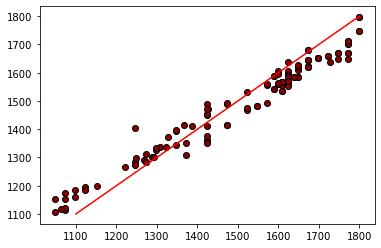

In [6]:
predicted_T=regr_T.predict(x_test_scaled)
plt.plot( y_test_T, predicted_T, 'ok', mfc='darkred')
plt.plot([1100, 1800], [1100, 1800], '-r')
Stats_T=pt.calculate_R2_np(y_test_T.values, predicted_T)
Stats_T['R2']
Stats_T['RMSE']

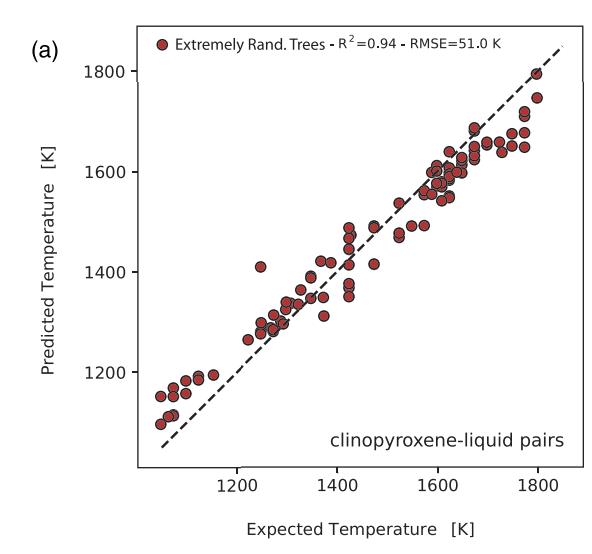

## Predicting the test data for Press

'RMSE= 2.90829'

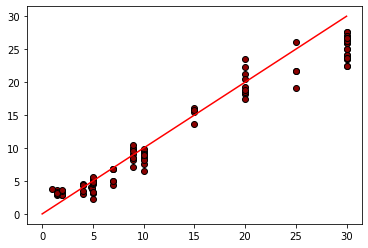

In [7]:
predicted_P=regr_P.predict(x_test_scaled)
plt.plot( y_test_P, predicted_P, 'ok', mfc='darkred')
plt.plot([0, 30], [0, 30], '-r')
Stats_P=pt.calculate_R2_np(y_test_P.values, predicted_P)
Stats_P['R2']
Stats_P['RMSE']

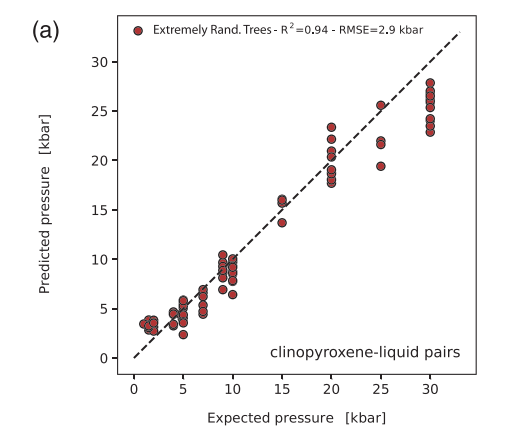

## New way, using onnx

In [17]:
#!pip install skl2onnx
from skl2onnx import __max_supported_opset__
print("Last supported opset:", __max_supported_opset__)
# Convert into ONNX format
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
initial_type = [('float_input', FloatTensorType([None, 22]))]
onx = convert_sklearn(regr_P, initial_types=initial_type)
with open("Cpx_only_regr_P_Feb1_Pet20.onnx", "wb") as f:
    f.write(onx.SerializeToString())

Last supported opset: 15


In [21]:
import onnxruntime as rt
import numpy
sess = rt.InferenceSession("Cpx_only_regr_P_Feb1_Pet20.onnx")
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
pred_onx = sess.run([label_name], {input_name: x_test_scaled.astype(numpy.float32)})[0]

In [22]:
pred_onx

array([[ 2.8607016],
       [ 3.4219244],
       [ 3.2365844],
       [ 9.041351 ],
       [10.029091 ],
       [ 9.838003 ],
       [ 7.127094 ],
       [ 8.420926 ],
       [ 8.151739 ],
       [10.516232 ],
       [ 9.581179 ],
       [ 8.545492 ],
       [ 5.024453 ],
       [ 6.841339 ],
       [ 4.452662 ],
       [ 6.770219 ],
       [ 4.447101 ],
       [ 3.0329158],
       [ 4.9382124],
       [ 6.795128 ],
       [ 4.5628457],
       [ 3.4884412],
       [ 4.4417806],
       [ 3.604693 ],
       [ 3.4003077],
       [ 3.7886014],
       [ 2.8692212],
       [ 2.8757646],
       [ 3.076173 ],
       [ 3.477873 ],
       [ 3.23291  ],
       [ 3.6009905],
       [21.764967 ],
       [21.68715  ],
       [19.165604 ],
       [18.207436 ],
       [18.434006 ],
       [ 9.437095 ],
       [ 9.540871 ],
       [ 9.919147 ],
       [ 8.645819 ],
       [ 8.479236 ],
       [ 8.393109 ],
       [ 6.525839 ],
       [ 9.1254635],
       [ 7.6507854],
       [ 8.153624 ],
       [ 8.94

## Old way of dumping in Joblib

In [9]:
# from pickle import dump
# dump(scaler, open('scaler_Petrelli2020_Cpx_Liq_Jan22.pkl', 'wb'))


# import joblib
# joblib.dump(regr_P,  'ETR_Press_Petrelli2020_Cpx_Liq_Jan22.pkl',compress=3)

# joblib.dump(regr_T,  'ETR_Temp_Petrelli2020_Cpx_Liq_Jan22.pkl',compress=3)

['ETR_Temp_Petrelli2020_Cpx_Liq_Jan22.pkl']